# Denoising Diffusion Models Part 3 - DDPM is actually a learnable and differentiable sampler.

This post follows on from the toy example in Part 2, and compares how the "latent" or seed compares with vae and DDPM.

In [141]:


import torch
from torch import nn
from torch.autograd import Variable

import numpy as np


from IPython.display import Image

Let's use a simple toy example I've used before; one hot vectors of size 4.

In [2]:


representation_size = 2
input_size = 4
n_samples = 2000
batch_size = 5

n_samples_per_batch = n_samples//input_size

y = np.array([i for i in range(input_size)  for _ in range(n_samples_per_batch)])

d = np.identity(input_size)
x = np.array([d[i] for i in y], dtype=np.float32)


print(x[[10, 58 ,610, 790, 1123, 1258, 1506, 1988]])



[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


Taken (and slighlty updated) from previous post on VAEs.

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.en1 = nn.Linear(input_size, 200)
        self.en_mu = nn.Linear(200, representation_size)
        self.en_std = nn.Linear(200, representation_size)
        self.de1 = nn.Linear(representation_size, 200)
        self.de2 = nn.Linear(200, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        """Encode a batch of samples, and return posterior parameters for each point."""
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z):
        """Decode a batch of latent variables"""
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def reparam(self, mu, logvar):
        """Reparameterisation trick to sample z values. 
        This is stochastic during training,  and returns the mode during evaluation."""
        
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x):
        """Takes a batch of samples, encodes them, and then decodes them again to compare."""
        mu, logvar = self.encode(x.view(-1, input_size))
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar
    
    def loss(self, reconstruction, x, mu, logvar):
        """ELBO assuming entries of x are binary variables, with closed form KLD."""
        
        bce = torch.nn.functional.binary_cross_entropy(reconstruction, x.view(-1, input_size))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= x.view(-1, input_size).data.shape[0] * input_size

        return bce + KLD
    
    def get_z(self, x):
        """Encode a batch of data points, x, into their z representations."""
        
        mu, logvar = self.encode(x.view(-1, input_size))
        return self.reparam(mu, logvar)

First, train a VAE on this dataset. 

In [4]:


vaemodel = VAE()



optimizer = torch.optim.Adam(vaemodel.parameters(), lr=1e-3)



def train(epoch, batches_per_epoch = 501, log_interval=500):
    vaemodel.train()
    
    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vaemodel(data)
        loss = vaemodel.loss(recon_batch, data, mu, logvar)
        loss.backward()
        #train_loss += loss.data[0]
        optimizer.step()
        if (i % log_interval == 0) and (epoch % 5 ==0):
            #Print progress
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, i * batch_size, batch_size*batches_per_epoch,
                loss.detach().numpy() / len(data)))

    print('====> Epoch: {} done!'.format(
          epoch))


def test(epoch, batches_per_epoch=1):
    vaemodel.eval()

    ind = np.arange(x.shape[0])
    for i in range(batches_per_epoch):
        
        data = torch.from_numpy(x[np.random.choice(ind, size=batch_size)])
        data = Variable(data, requires_grad=False)
        recon_batch, mu, logvar = vaemodel(data)
        if i == 0:
            n = min(data.size(0), 2)
            print(data.view(batch_size, 2,2)[:n])
            print(recon_batch.view(batch_size, 2,2)[:n])



In [5]:


print_examples = False #Change to true if you want to see some examples at each step!
for epoch in range(1, 30):
    train(epoch)
    if print_examples:
        test(epoch)



====> Epoch: 1 done!
====> Epoch: 2 done!
====> Epoch: 3 done!
====> Epoch: 4 done!
Train Epoch: 5 [0/2505]	Loss: 0.077024
Train Epoch: 5 [2500/2505]	Loss: 0.109691
====> Epoch: 5 done!
====> Epoch: 6 done!
====> Epoch: 7 done!
====> Epoch: 8 done!
====> Epoch: 9 done!
Train Epoch: 10 [0/2505]	Loss: 0.088970
Train Epoch: 10 [2500/2505]	Loss: 0.074725
====> Epoch: 10 done!
====> Epoch: 11 done!
====> Epoch: 12 done!
====> Epoch: 13 done!
====> Epoch: 14 done!
Train Epoch: 15 [0/2505]	Loss: 0.082211
Train Epoch: 15 [2500/2505]	Loss: 0.081925
====> Epoch: 15 done!
====> Epoch: 16 done!
====> Epoch: 17 done!
====> Epoch: 18 done!
====> Epoch: 19 done!
Train Epoch: 20 [0/2505]	Loss: 0.072776
Train Epoch: 20 [2500/2505]	Loss: 0.073927
====> Epoch: 20 done!
====> Epoch: 21 done!
====> Epoch: 22 done!
====> Epoch: 23 done!
====> Epoch: 24 done!
Train Epoch: 25 [0/2505]	Loss: 0.073541
Train Epoch: 25 [2500/2505]	Loss: 0.064901
====> Epoch: 25 done!
====> Epoch: 26 done!
====> Epoch: 27 done!
==

In [11]:

vae_sample = np.concatenate([x]*10)
vae_class = np.concatenate([y]*10)

data = Variable(torch.from_numpy(vae_sample), requires_grad=False)
vaemodel.train()
zs = vaemodel.get_z(data).data.numpy()



And now we can visualise the representation distribution for each class.

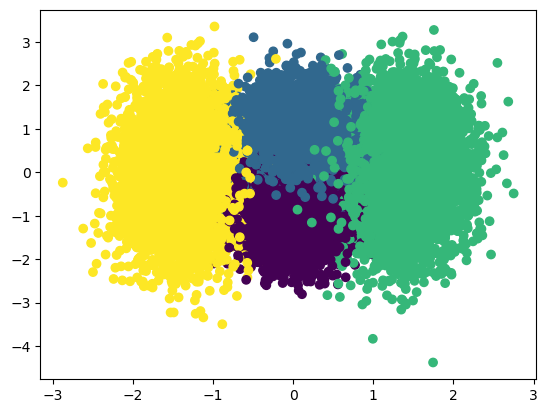

In [12]:


import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(zs[:,0], zs[:, 1], c=vae_class)



### DDPM

Now, let's train a DDPM on the latent representations of the VAE, as lots of the big stable diffusion type models do with images.

In [14]:
class LinearNoiseScheduler:
    def __init__(self, start, end, T):
        self.start = start
        self.end = end
        self.T = T
        self.alpha_bars = None
        self.precompute_alpha_bar()
        
    def get_variance(self, t):
        return self.start + (self.end - self.start)*(t-1)/(self.T-1)
        
    def get_alpha(self, t):
        return 1-self.get_variance(t)
        
    def get_alpha_bar(self, t):
        assert self.alpha_bars is not None
        
        return self.alpha_bars[t-1]
        
    def precompute_alpha_bar(self):
        tmp = np.zeros((self.T))
        
        for i in range(self.T):
            tmp[i-1] = self.get_alpha(i)
            
        self.alpha_bars = np.cumprod(tmp)

In [15]:
class SkipLayer(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.l = torch.nn.Linear(input_dim, input_dim, bias=False)
        
    def forward(self, x):
        return self.l(x) + x

class Model(torch.nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.input_dim = input_dim

        
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_dim+2, 5), # add 2 because input_dim is the vector size, and need two for the time embedding.
            torch.nn.ReLU(),
            torch.nn.Linear(5, 3),
            torch.nn.ReLU(),
            SkipLayer(3),
            torch.nn.ReLU(),
            SkipLayer(3),
            torch.nn.ReLU(),
            torch.nn.Linear(3, input_dim)
        )
        
    def forward(self, x):
        return self.net(x)
            
            

In [16]:
# Hyperparams - beta from the paper, T is half the paper due to problem simplicity, probably could be even smaller 
T = 500
beta_1 = 10e-4
beta_1000 = 0.02

def augment_data(x_0, alpha_bar_t, noise, t):
    assert x_0.shape == noise.shape
    x_t = np.sqrt(alpha_bar_t)*x_0 + np.sqrt(1-alpha_bar_t)*noise
    return np.hstack([x_t, np.cos(t.reshape(-1,1)/T), np.sin(t.reshape(-1,1)/T)])

In [17]:
lns = LinearNoiseScheduler(beta_1, beta_1000, T)

In [18]:
def get_batch(x0):
    n_times_per_batch = 5 # Replicate our full dataset this many times in each batch.
    input_data = []
    targets = []
    for i in range(n_times_per_batch):
        t = np.random.randint(1, T, size=(zs.shape[0],))
        alpha_bar_ts = np.array([lns.get_alpha_bar(x) for x in t]).reshape(-1,1)
        eps = np.random.normal(0, 1,size=zs.shape)
        new_data = augment_data(x0, alpha_bar_ts, eps, t)
        input_data.append(new_data)
        targets.append(eps)
        
    X = np.concatenate(input_data)
    y = np.concatenate(targets)
    return X,y

In [19]:
model = Model(2).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_f = torch.nn.MSELoss()
losses = []
val_losses = []
for i in range(80000):
    X,y = get_batch(zs)
    X = torch.tensor(X, dtype=torch.float32).to("cuda")
    y = torch.tensor(y, dtype=torch.float32).to("cuda")
    y_pred = model(X)
    loss = loss_f(y_pred, y)
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # if i % 10 == 0 :
    #     with torch.no_grad():
    #         X_val,y_val = get_batch(data_validation)
    #         X_val = torch.tensor(X_val, dtype=torch.float32).to("cuda")
    #         y_val = torch.tensor(y_val, dtype=torch.float32).to("cuda")
    #         y_pred_val = model(X_val)
    #         val_loss = loss_f(y_pred_val, y_val)
    #         val_losses.append(val_loss.cpu().detach().numpy())
    losses.append(loss.cpu().detach().numpy())

In [20]:
import pandas as pd

loss_ts = pd.Series(losses)

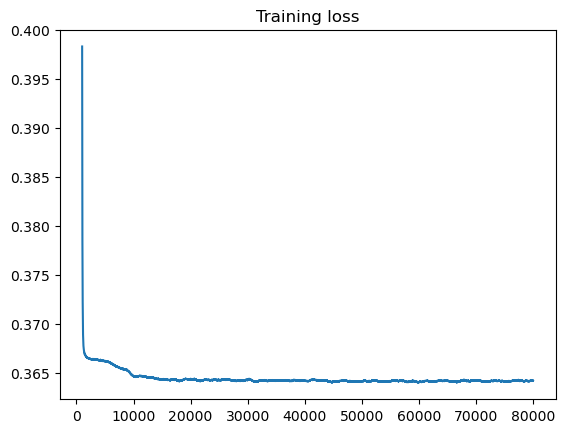

In [21]:
loss_ts.rolling(1000).mean().plot( title='Training loss');

In [96]:
def sample(denoise=True):
    samples = []
    seeds = []
    trajectory = []
    x_t = np.random.normal(size=(1000,representation_size))
    seeds.append(x_t)
    for t in np.arange(T, 0, -1, dtype=int):
        trajectory.append(x_t)
        t_tmp = np.array([t]*1000, dtype=np.float32).reshape(-1,1)
        x_inp = torch.tensor(np.concatenate([x_t, np.cos(t_tmp/T), np.sin(t_tmp/T)], axis=1), dtype=torch.float32).to("cuda")
        n_pred = model(x_inp)
        n_pred = n_pred.cpu().detach().numpy()
        x_t_1 = (x_t - n_pred*(1-lns.get_alpha(t))/np.sqrt(1-lns.get_alpha_bar(t)))/np.sqrt(lns.get_alpha(t))
        if t>1 and denoise:
            x_t_1 += np.sqrt(lns.get_variance(t))*np.random.normal(size=(1000,representation_size))
        x_t = x_t_1

    samples.append(x_t_1)
    trajectory.append(x_t_1)
    return seeds, samples, trajectory

In [114]:
seeds, samples, trajectory = sample()
samples = np.concatenate(samples)
seeds = np.concatenate(seeds)
decoded_samples = vaemodel.decode(torch.tensor(samples, dtype=torch.float32)).detach().numpy()
decoded_class = decoded_samples.argmax(axis=1)

Due to the problem size, we can actually visualise the evolution of the representations. Here, I've used the standard sampling algorithm (which adds noise at each step), and picked some random time steps.

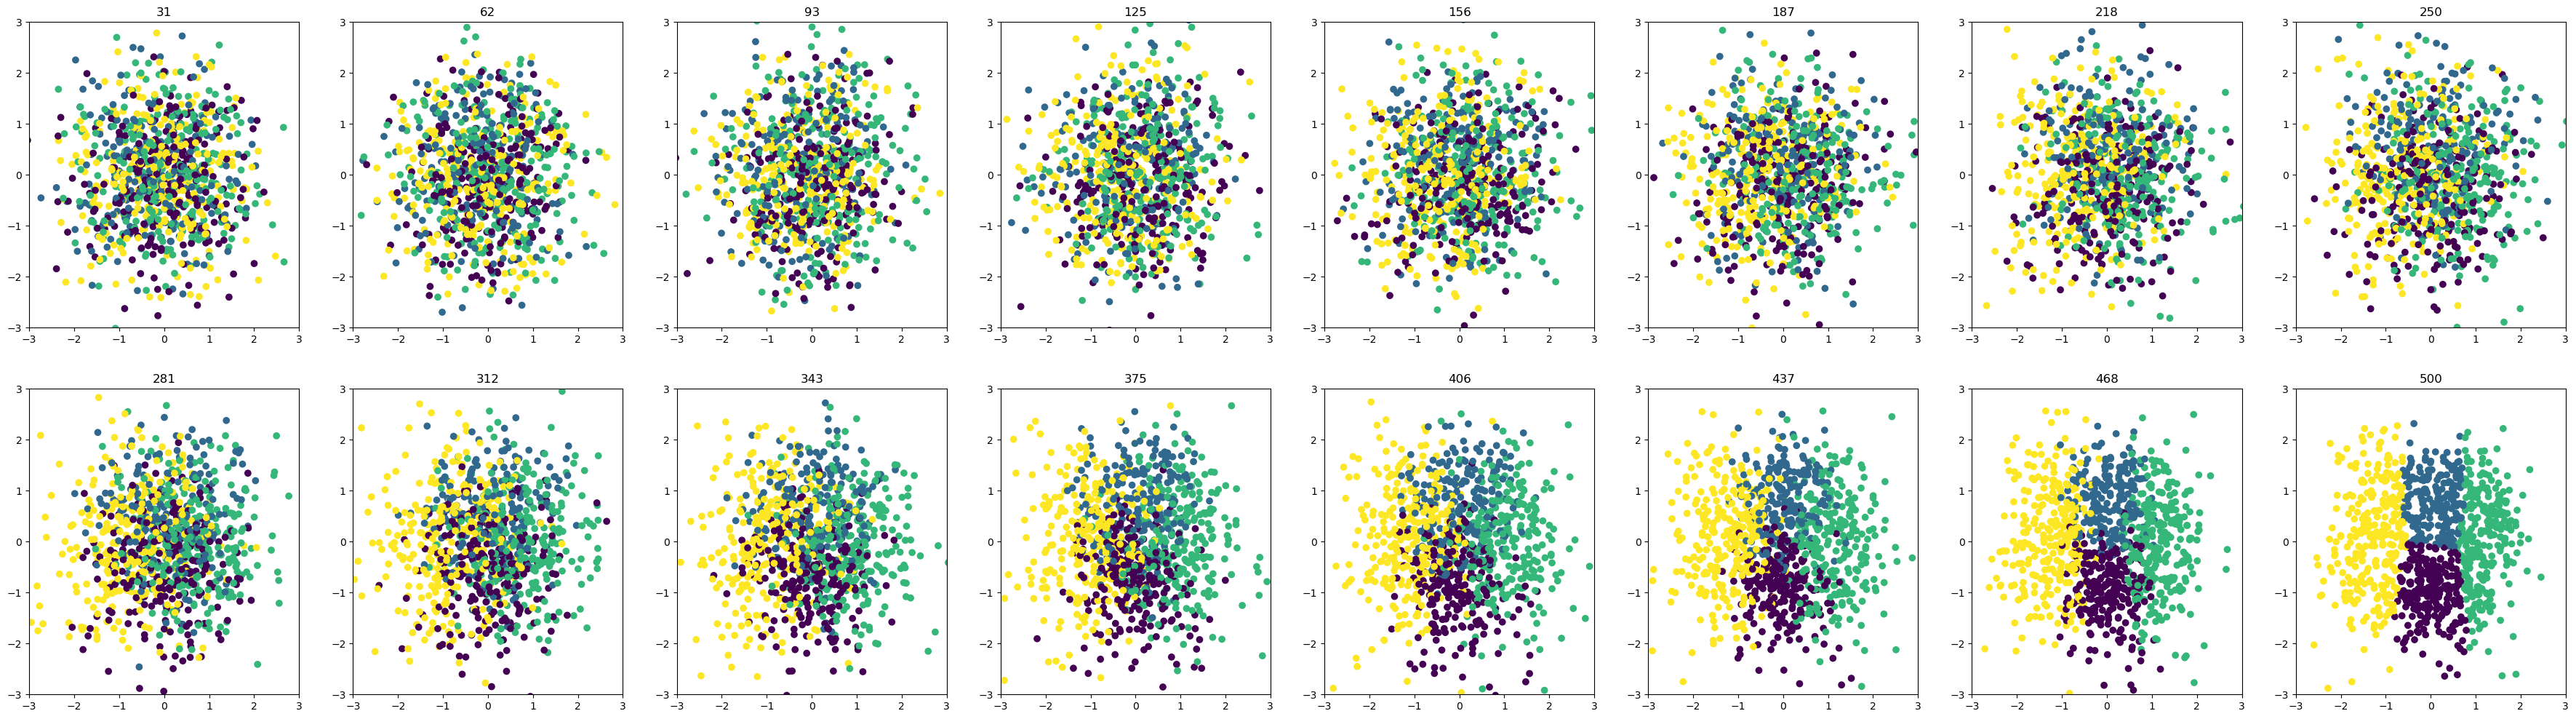

In [115]:
fig, axes = plt.subplots(2,8, figsize=(45,12))
for i,ax in enumerate(axes.ravel()):
    idx = (i+1)*500//16
    ax.scatter(trajectory[idx][:,0], trajectory[idx][:,1], c=decoded_class)
    ax.set_title(f"{idx}")
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])

In [134]:
seeds, samples, trajectory = sample(denoise=False)
samples = np.concatenate(samples)
seeds = np.concatenate(seeds)
decoded_samples_ddim = vaemodel.decode(torch.tensor(samples, dtype=torch.float32)).detach().numpy()
decoded_class = decoded_samples.argmax(axis=1)


Interestingly, if we omit adding the noise, we see very different behaviour...

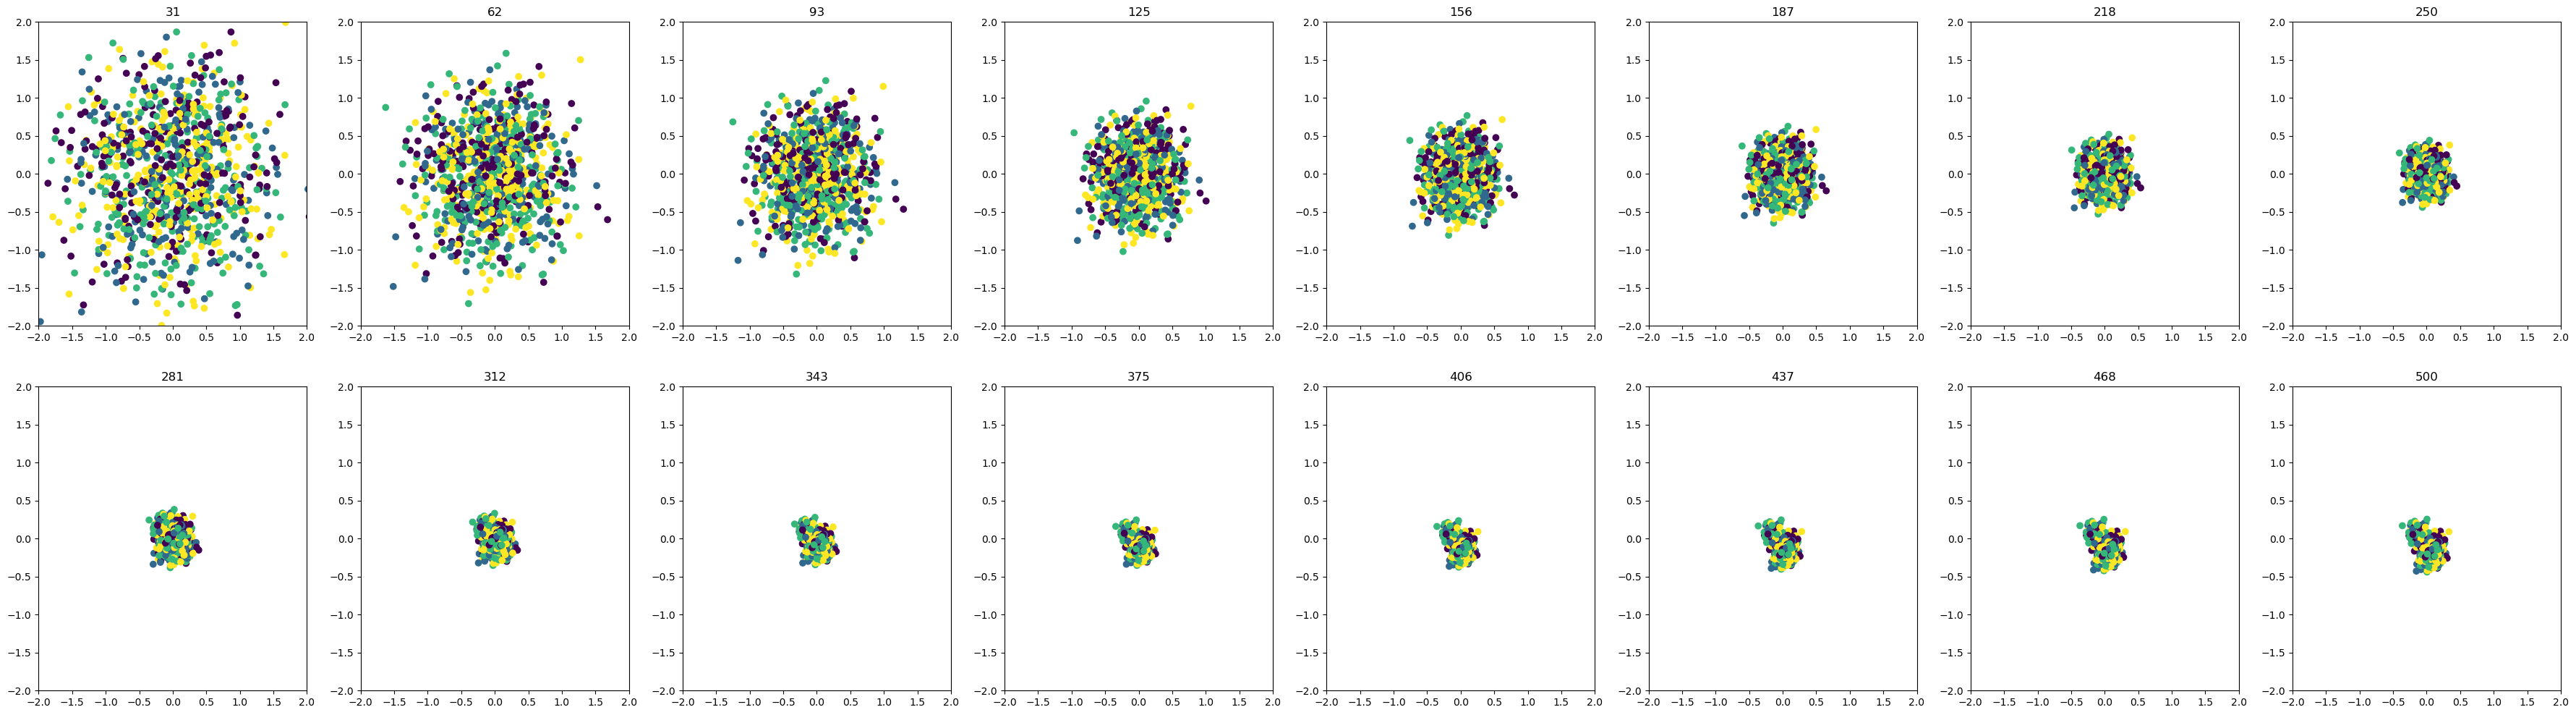

In [136]:
fig, axes = plt.subplots(2,8, figsize=(45,12))
for i,ax in enumerate(axes.ravel()):
    idx = (i+1)*500//16
    ax.scatter(trajectory[idx][:,0], trajectory[idx][:,1], c=decoded_class)
    ax.set_title(f"{idx}")
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])

In [127]:
np.set_printoptions(suppress=True, precision=3)

In [137]:
decoded_samples[:8]

array([[0.   , 0.   , 0.999, 0.   ],
       [0.001, 0.98 , 0.001, 0.01 ],
       [0.734, 0.   , 0.27 , 0.   ],
       [0.96 , 0.   , 0.   , 0.025],
       [0.   , 0.   , 0.   , 1.   ],
       [0.881, 0.019, 0.078, 0.   ],
       [0.001, 0.014, 0.   , 0.985],
       [0.   , 0.006, 0.   , 0.996]], dtype=float32)

In [138]:
decoded_samples_ddim[:8]

array([[0.718, 0.382, 0.003, 0.004],
       [0.657, 0.427, 0.001, 0.009],
       [0.634, 0.482, 0.005, 0.002],
       [0.236, 0.817, 0.002, 0.006],
       [0.828, 0.233, 0.002, 0.004],
       [0.772, 0.317, 0.005, 0.002],
       [0.735, 0.359, 0.002, 0.004],
       [0.762, 0.321, 0.002, 0.005]], dtype=float32)

As the print shows, at least for this toy example, not adding noise leads to samples which are less "good". 

## Some thoughts

What's clear here, is that in normal sampling mode, the DDPM is not acting like a representation learner per se - it is not segmenting the "seed space" (i.e. the domain of input noise), but is in fact acting more like a traditional sampling algorithm - it is best thought of as akin to a peer to something like MCMC sampling. <br/>At each step our neural net is trying to steer towards higher probability regions of the space. This is why we don't get "nice" representations - at each step we do a small random step, and then move as per our network instructs. As such, the values of these pertubations mean that for each seed there are almost infinite possible samples to be drawn.


# Summary

What is really cool, is that actually these DDPMs are learnable sampling routines. There is a whole array of literature and tooling that tackles how we might draw samples from a variety of hard distributions - such as bayesian models. <br/>
With DDPM we can specify our sampling chain length (number of steps), and learn a specific sampler for the task we want, rather than using more generalised approaches like HMC which are much less effective as the problem scales, because they have to make fewer assumptions.